<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 1 | Setup and Analysis</p>

# <b></span><span style='color:#87CEEB'> Importing Necessary Libraries</span></b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# <b></span><span style='color:#87CEEB'> Load dataware house</span></b>

In [2]:
df_flights = pd.read_csv('Datasets/voos_completos_clima.csv')

# <b></span><span style='color:#87CEEB'> Initial Data Analysis</span></b>

In [3]:
df_flights.head(10)

,nr_voo,data_partida,nome_companhia_aerea,id_companhia_aerea,pais_companhia_aerea,aeroporto_origem,nome_aeroporto_origem,pais_aeroporto_origem,cidade_aeroporto_origem,latitude_aeroporto_origem,...,atraso_voo_anterior,Modelo_Avião,Fabricante,avaliacao,temperatura,precipitacao,visibilidade,cobertura_nuvens,velocidade,direcao
0,1562,2019-01-09,United Airlines,UA,United States,FLL,Fort Lauderdale Hollywood International Airport,United States,Fort Lauderdale,26.072599,...,NaN,Airbus A320,Airbus,2.4,24.707943,2.930989,10.286996,42.902462,17.763297,234.822503
1,1149,2022-11-19,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,NaN,Airbus A300,Airbus,7.1,21.894861,3.750816,9.283380,45.925146,5.454128,215.090545
2,459,2022-07-22,United Airlines,UA,United States,DEN,Denver International Airport,United States,Denver,39.861698,...,NaN,Airbus A340,Airbus,4.2,17.453724,4.575866,9.668414,11.275358,18.114917,253.237576
3,2295,2023-03-06,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,0.0,Boeing 767-200,Boeing,3.3,21.749921,1.156845,13.642514,45.410799,43.830962,10.760631
4,407,2020-02-23,Spirit Airlines,NK,United States,MCO,Orlando International Airport,United States,Orlando,28.429399,...,NaN,Airbus A330-200,Airbus,0.5,17.241807,1.389318,10.046560,43.422224,10.685583,269.114562
5,665,2019-07-31,Southwest Airlines,WN,United States,DAL,Dallas Love Field,United States,Dallas,32.847099,...,0.0,Boeing 747-400,Boeing,4.8,21.752222,17.694242,8.924453,48.736524,6.768047,336.180597
6,2134,2023-06-11,American Airlines,AA,United States,DCA,Ronald Reagan Washington National Airport,United States,Washington,38.852100,...,NaN,Boeing 787-10,Boeing,5.5,22.709606,3.152942,10.806620,46.453579,16.323853,7.840859
7,4464,2019-07-08,Midwest Airlines,YX,United States,HSV,Huntsville International Carl T Jones Field,United States,Huntsville,34.637199,...,0.0,Boeing 727,Boeing,3.3,24.674139,0.631494,12.180694,39.225293,27.530856,237.178121
8,590,2023-02-12,Spirit Airlines,NK,United States,IAH,George Bush Intercontinental Houston Airport,United States,Houston,29.984400,...,NaN,Airbus A330,Airbus,2.2,24.100101,4.723317,13.826943,0.564220,17.648984,331.737519
9,223,2020-08-22,Alaska Airlines,AS,ALASKA,SEA,Seattle Tacoma International Airport,United States,Seattle,47.449001,...,NaN,Airbus A330-200,Airbus,1.8,20.023194,0.415273,14.443763,8.842384,18.548913,288.860415


In [4]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 38 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   nr_voo                       int64  
 1   data_partida                 object 
 2   nome_companhia_aerea         object 
 3   id_companhia_aerea           object 
 4   pais_companhia_aerea         object 
 5   aeroporto_origem             object 
 6   nome_aeroporto_origem        object 
 7   pais_aeroporto_origem        object 
 8   cidade_aeroporto_origem      object 
 9   latitude_aeroporto_origem    float64
 10  longitude_aeroporto_origem   float64
 11  aeroporto_destino            object 
 12  nome_aeroporto_destino       object 
 13  pais_aeroporto_destino       object 
 14  cidade_aeroporto_destino     object 
 15  latitude_aeroporto_destino   float64
 16  longitude_aeroporto_destino  float64
 17  hora_partida_real            float64
 18  hora_partida_esperada        int64  
 19  

In [5]:
# Summary statistics for numerical variables
df_flights.describe().T

,count,mean,std,min,25%,50%,75%,max
nr_voo,3000000.0,2511.535519,1747.258040,1.000000e+00,1051.000000,2152.000000,3797.000000,9562.000000
latitude_aeroporto_origem,2999265.0,36.688177,6.011262,-1.433100e+01,32.898602,37.362598,40.777199,71.285402
longitude_aeroporto_origem,2999265.0,-94.806949,18.432813,-1.766460e+02,-110.941002,-87.904800,-80.943100,145.729004
latitude_aeroporto_destino,2999238.0,36.684660,6.013082,-1.433100e+01,32.898602,37.362598,40.777199,71.285402
longitude_aeroporto_destino,2999238.0,-94.809625,18.448716,-1.766460e+02,-110.941002,-87.904800,-80.943100,145.729004
hora_partida_real,2922385.0,1329.775913,499.310052,1.000000e+00,916.000000,1323.000000,1739.000000,2400.000000
hora_partida_esperada,3000000.0,1327.061984,485.878854,1.000000e+00,915.000000,1320.000000,1730.000000,2359.000000
hora_chegada_real,2920058.0,1466.511162,531.838349,1.000000e+00,1053.000000,1505.000000,1913.000000,2400.000000
hora_chegada_esperada,3000000.0,1490.560665,511.547566,1.000000e+00,1107.000000,1516.000000,1919.000000,2400.000000
cancelado,3000000.0,0.026380,0.160263,0.000000e+00,0.000000,0.000000,0.000000,1.000000


In [6]:
# Summary statistics for categorical variables
df_flights.describe(include='object').T

,count,unique,top,freq
data_partida,3000000,1704,2019-07-25,2379
nome_companhia_aerea,3000000,18,Southwest Airlines,576470
id_companhia_aerea,3000000,18,WN,576470
pais_companhia_aerea,3000000,2,United States,2899533
aeroporto_origem,2999265,378,ATL,153556
nome_aeroporto_origem,2999265,378,Hartsfield Jackson Atlanta International Airport,153556
pais_aeroporto_origem,2999265,6,United States,2981743
cidade_aeroporto_origem,2999265,362,Chicago,157368
aeroporto_destino,2999238,378,ATL,153569
nome_aeroporto_destino,2999238,378,Hartsfield Jackson Atlanta International Airport,153569


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 2 | Data Cleaning</p>

# <b></span><span style='color:#87CEEB'> Treating Cancelled and Diverted Flights</span></b>

In [7]:
df_cancelados = df_flights[df_flights["cancelado"] == 1.0].copy()
df_desviados = df_flights[df_flights["desviado"] == 1.0].copy()

In [8]:
diverted_percentage = (df_desviados.shape[0] / df_flights.shape[0]) * 100
cancelled_percentage = (df_cancelados.shape[0] / df_flights.shape[0]) * 100

In [9]:
print(f"Cancelled flights%: {cancelled_percentage:.2f}\n Diverted flights%: {diverted_percentage:.2f}")

Cancelled flights%: 2.64
 Diverted flights%: 0.24


# <b></span><span style='color:#87CEEB'> Handling Nulls</span></b>

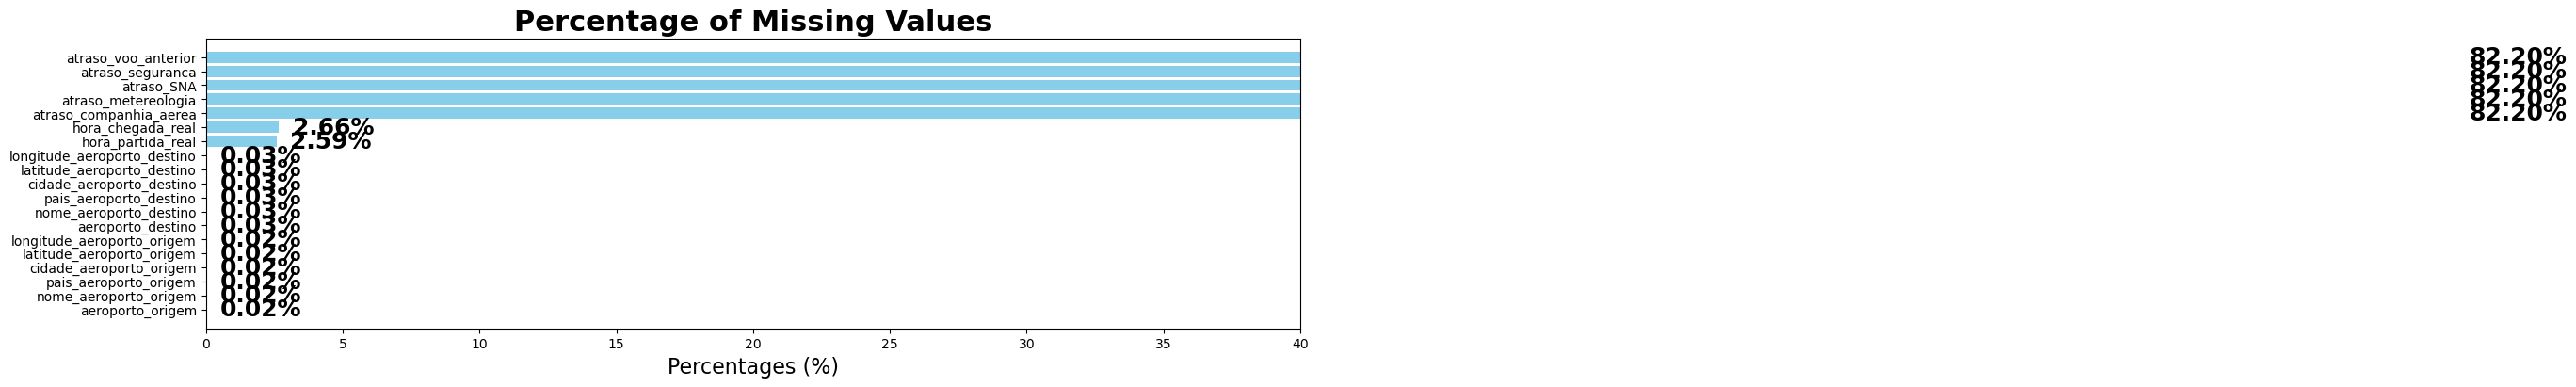

In [10]:
# Calculating the percentage of missing values for each column
missing_data = df_flights.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df_flights.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#87CEEB')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [11]:
df_flights_clean = df_flights.dropna(subset=["hora_partida_real","hora_chegada_real", "longitude_aeroporto_origem", "aeroporto_origem", "aeroporto_destino", "latitude_aeroporto_destino"]).copy()

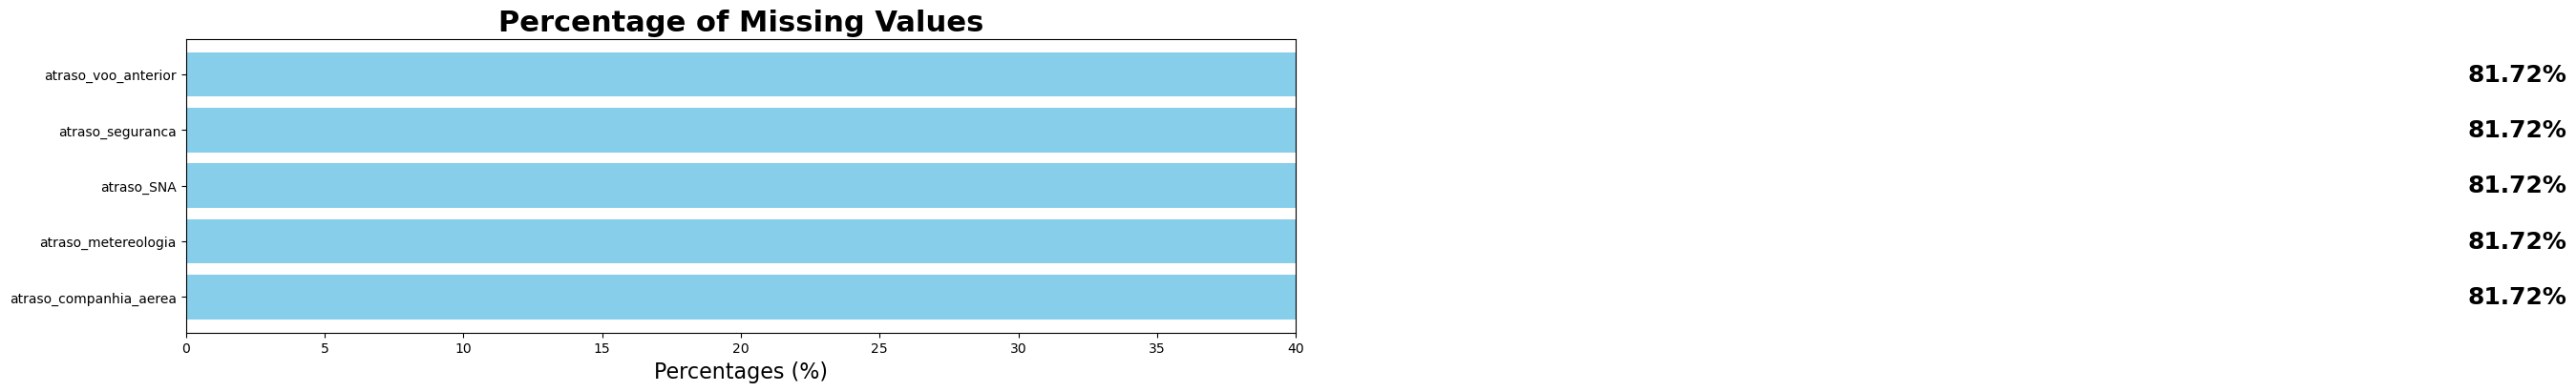

In [12]:
# Calculating the percentage of missing values for each column
missing_data = df_flights_clean.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df_flights_clean.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#87CEEB')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [13]:
def hhmm_to_minutes(hhmm):
    # Converter valores nulos ou inválidos
    try:
        hhmm = int(hhmm)
        hours = hhmm // 100
        minutes = hhmm % 100
        return hours * 60 + minutes
    except:
        return None

# Converter os tempos para minutos
df_flights_clean.loc[:, "DEP_TIME_MIN"] =  df_flights_clean["hora_partida_real"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "CRS_DEP_TIME_MIN"] =  df_flights_clean["hora_partida_esperada"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "ARR_TIME_MIN"] =  df_flights_clean["hora_chegada_real"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "CRS_ARR_TIME_MIN"] =  df_flights_clean["hora_chegada_esperada"].apply(hhmm_to_minutes)

#for col in ["DEP_TIME", "CRS_DEP_TIME", "ARR_TIME", "CRS_ARR_TIME"]:
#    df_flights_clean[col + "_MIN"] = df_flights_clean[col].apply(hhmm_to_minutes)

# Calcular o TOTAL_DELAY
df_flights_clean["atraso_partida"] = (
    df_flights_clean["DEP_TIME_MIN"] - df_flights_clean["CRS_DEP_TIME_MIN"]
)

df_flights_clean["atraso_chegada"] = (
    df_flights_clean["ARR_TIME_MIN"] - df_flights_clean["CRS_ARR_TIME_MIN"]
)


In [14]:
df_flights_clean.head(10)

,nr_voo,data_partida,nome_companhia_aerea,id_companhia_aerea,pais_companhia_aerea,aeroporto_origem,nome_aeroporto_origem,pais_aeroporto_origem,cidade_aeroporto_origem,latitude_aeroporto_origem,...,visibilidade,cobertura_nuvens,velocidade,direcao,DEP_TIME_MIN,CRS_DEP_TIME_MIN,ARR_TIME_MIN,CRS_ARR_TIME_MIN,atraso_partida,atraso_chegada
0,1562,2019-01-09,United Airlines,UA,United States,FLL,Fort Lauderdale Hollywood International Airport,United States,Fort Lauderdale,26.072599,...,10.286996,42.902462,17.763297,234.822503,711,715,887,901,-4,-14
1,1149,2022-11-19,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,9.283380,45.925146,5.454128,215.090545,1274,1280,1390,1395,-6,-5
2,459,2022-07-22,United Airlines,UA,United States,DEN,Denver International Airport,United States,Denver,39.861698,...,9.668414,11.275358,18.114917,253.237576,600,594,772,772,6,0
3,2295,2023-03-06,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,13.642514,45.410799,43.830962,10.760631,968,969,1133,1109,-1,24
4,407,2020-02-23,Spirit Airlines,NK,United States,MCO,Orlando International Airport,United States,Orlando,28.429399,...,10.046560,43.422224,10.685583,269.114562,1118,1120,1240,1241,-2,-1
5,665,2019-07-31,Southwest Airlines,WN,United States,DAL,Dallas Love Field,United States,Dallas,32.847099,...,8.924453,48.736524,6.768047,336.180597,757,610,811,670,147,141
6,2134,2023-06-11,American Airlines,AA,United States,DCA,Ronald Reagan Washington National Airport,United States,Washington,38.852100,...,10.806620,46.453579,16.323853,7.840859,601,610,690,719,-9,-29
7,4464,2019-07-08,Midwest Airlines,YX,United States,HSV,Huntsville International Carl T Jones Field,United States,Huntsville,34.637199,...,12.180694,39.225293,27.530856,237.178121,997,1003,1208,1185,-6,23
8,590,2023-02-12,Spirit Airlines,NK,United States,IAH,George Bush Intercontinental Houston Airport,United States,Houston,29.984400,...,13.826943,0.564220,17.648984,331.737519,327,330,426,437,-3,-11
9,223,2020-08-22,Alaska Airlines,AS,ALASKA,SEA,Seattle Tacoma International Airport,United States,Seattle,47.449001,...,14.443763,8.842384,18.548913,288.860415,1276,1285,1436,1435,-9,1


In [15]:
df_cancelados1 = df_flights_clean[df_flights_clean["cancelado"] == 1.0].copy()
df_desviados1 = df_flights_clean[df_flights_clean["desviado"] == 1.0].copy()

cancelled_percentage = (df_cancelados1.shape[0] / df_flights_clean.shape[0]) * 100
diverted_percentage = (df_desviados1.shape[0] / df_flights_clean.shape[0]) * 100

print(f"Cancelled flights%: {cancelled_percentage:.2f}\n Diverted flights%: {diverted_percentage:.2f}")


Cancelled flights%: 0.00
 Diverted flights%: 0.21


In [16]:
df_flights_clean = df_flights_clean[(df_flights["desviado"] != 1.0)].copy()

/tmp/ipykernel_22835/1599452511.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_flights_clean = df_flights_clean[(df_flights["desviado"] != 1.0)].copy()


In [17]:
df_flights_clean.drop(["cancelado", "desviado", "DEP_TIME_MIN", "CRS_DEP_TIME_MIN", "ARR_TIME_MIN", "CRS_ARR_TIME_MIN"], axis=1, inplace=True)

In [18]:
df_flights_clean.head(10)

,nr_voo,data_partida,nome_companhia_aerea,id_companhia_aerea,pais_companhia_aerea,aeroporto_origem,nome_aeroporto_origem,pais_aeroporto_origem,cidade_aeroporto_origem,latitude_aeroporto_origem,...,Fabricante,avaliacao,temperatura,precipitacao,visibilidade,cobertura_nuvens,velocidade,direcao,atraso_partida,atraso_chegada
0,1562,2019-01-09,United Airlines,UA,United States,FLL,Fort Lauderdale Hollywood International Airport,United States,Fort Lauderdale,26.072599,...,Airbus,2.4,24.707943,2.930989,10.286996,42.902462,17.763297,234.822503,-4,-14
1,1149,2022-11-19,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,Airbus,7.1,21.894861,3.750816,9.283380,45.925146,5.454128,215.090545,-6,-5
2,459,2022-07-22,United Airlines,UA,United States,DEN,Denver International Airport,United States,Denver,39.861698,...,Airbus,4.2,17.453724,4.575866,9.668414,11.275358,18.114917,253.237576,6,0
3,2295,2023-03-06,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,Boeing,3.3,21.749921,1.156845,13.642514,45.410799,43.830962,10.760631,-1,24
4,407,2020-02-23,Spirit Airlines,NK,United States,MCO,Orlando International Airport,United States,Orlando,28.429399,...,Airbus,0.5,17.241807,1.389318,10.046560,43.422224,10.685583,269.114562,-2,-1
5,665,2019-07-31,Southwest Airlines,WN,United States,DAL,Dallas Love Field,United States,Dallas,32.847099,...,Boeing,4.8,21.752222,17.694242,8.924453,48.736524,6.768047,336.180597,147,141
6,2134,2023-06-11,American Airlines,AA,United States,DCA,Ronald Reagan Washington National Airport,United States,Washington,38.852100,...,Boeing,5.5,22.709606,3.152942,10.806620,46.453579,16.323853,7.840859,-9,-29
7,4464,2019-07-08,Midwest Airlines,YX,United States,HSV,Huntsville International Carl T Jones Field,United States,Huntsville,34.637199,...,Boeing,3.3,24.674139,0.631494,12.180694,39.225293,27.530856,237.178121,-6,23
8,590,2023-02-12,Spirit Airlines,NK,United States,IAH,George Bush Intercontinental Houston Airport,United States,Houston,29.984400,...,Airbus,2.2,24.100101,4.723317,13.826943,0.564220,17.648984,331.737519,-3,-11
9,223,2020-08-22,Alaska Airlines,AS,ALASKA,SEA,Seattle Tacoma International Airport,United States,Seattle,47.449001,...,Airbus,1.8,20.023194,0.415273,14.443763,8.842384,18.548913,288.860415,-9,1


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 3 | Feature Engineering</p>

# <b></span><span style='color:#87CEEB'> RFM Features</span></b>

<div style="border-radius:10px; padding:15px; background-color:#87CEEB; font-size:120%; text-align:left; color: black;">
  <h2>Recency</h2>
  <p>Vamos usar a <b>recência</b> para analisar quão recente foi o último atraso.</p>

  <h2>Frequency</h2>
  <p>A <b>frequência</b> nos permite descobrir se os atrasos são acontecimentos recorrentes.</p>

  <h2>Monetary</h2>
  <p>Qual é a <b>quantidade</b> total de atrasos? aplicar aos aeroportos? companhias aereas? aos dois? Nem sei se faz sentido aplicar isto aqui ou nao</p>
</div>

# <b></span><span style='color:#87CEEB'> RFM Airline</span></b>

In [19]:
# Convert data_partida to datetime type
df_flights_clean['data_partida'] = pd.to_datetime(df_flights_clean['data_partida'])

# Convert data_partida to datetime and extract only the date
df_flights_clean['data_partida'] = df_flights_clean['data_partida'].dt.date

df_flights_clean['rota'] = df_flights_clean['aeroporto_origem'] + '-' + df_flights_clean['aeroporto_destino']

# Filtrar apenas os voos com atraso na chegada
df_atrasados = df_flights_clean[df_flights_clean['atraso_chegada'] > 0]

In [20]:
#df_atrasados.describe().T

In [21]:
# Calcular última data de atraso por companhia
last_delay = df_atrasados.groupby('id_companhia_aerea')['data_partida'].max().reset_index()
last_delay.rename(columns={'data_partida': 'data_ultimo_atraso'}, inplace=True)

all_airlines = df_flights_clean[['id_companhia_aerea']].drop_duplicates()

# Mesclar para manter todas as companhias, mesmo sem atrasos
airline_data = pd.merge(all_airlines, last_delay, on='id_companhia_aerea', how='left')

# Garantir que a coluna data_ultimo_atraso está no formato datetime
airline_data['data_ultimo_atraso'] = pd.to_datetime(airline_data['data_ultimo_atraso'])

# Calcular data de referência (última data do dataset)
data_base = df_flights_clean['data_partida'].max()
data_base = pd.to_datetime(data_base)

# Calcular recência (dias desde o último atraso)
airline_data['dias_desde_ultimo_atraso'] = (data_base - airline_data['data_ultimo_atraso']).dt.days

airline_data.head()

,id_companhia_aerea,data_ultimo_atraso,dias_desde_ultimo_atraso
0,UA,2023-08-31,0
1,DL,2023-08-31,0
2,NK,2023-08-31,0
3,WN,2023-08-31,0
4,AA,2023-08-31,0


In [22]:
# Calculate the total number of flights made by each airline
nr_total_voos = df_flights_clean['id_companhia_aerea'].value_counts().reset_index()
nr_total_voos.columns = ['id_companhia_aerea', 'nr_total_voos']

# Merge the new features into the airline_data dataframe
airline_data = pd.merge(airline_data, nr_total_voos, on='id_companhia_aerea')

# Display the first few rows of the airline_data dataframe
airline_data.head()

,id_companhia_aerea,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos
0,UA,2023-08-31,0,248270
1,DL,2023-08-31,0,388475
2,NK,2023-08-31,0,93200
3,WN,2023-08-31,0,555869
4,AA,2023-08-31,0,371218


In [23]:
atraso_total = df_flights_clean.groupby('id_companhia_aerea')['atraso_chegada'].sum().reset_index()

# Calculate the average transaction value for each customer
atraso_medio = atraso_total.merge(nr_total_voos, on='id_companhia_aerea')
atraso_medio['atraso_medio'] = atraso_medio['atraso_chegada'] / atraso_medio['nr_total_voos']
atraso_medio['atraso_medio'] = atraso_medio['atraso_medio'].round(2)

# Merge the new features into the airline_data dataframe
airline_data = pd.merge(airline_data, atraso_total, on='id_companhia_aerea')
airline_data = pd.merge(airline_data, atraso_medio[['id_companhia_aerea', 'atraso_medio']], on='id_companhia_aerea')

In [24]:
airline_data.describe().T

,count,mean,min,25%,50%,75%,max,std
data_ultimo_atraso,18,2023-06-05 17:20:00,2020-09-28 00:00:00,2023-08-31 00:00:00,2023-08-31 00:00:00,2023-08-31 00:00:00,2023-08-31 00:00:00,NaN
dias_desde_ultimo_atraso,18.0,86.277778,0.0,0.0,0.0,0.0,1067.0,256.97306
nr_total_voos,18.0,161798.055556,17951.0,62535.5,106465.0,220739.25,555869.0,152898.088512
atraso_chegada,18.0,-2269896.388889,-7048505.0,-2875384.25,-1679015.0,-801081.5,-86784.0,2085805.315882
atraso_medio,18.0,-14.406667,-27.48,-20.8225,-12.795,-9.07,-2.74,7.622923


In [25]:
airline_data.head()

,id_companhia_aerea,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso_chegada,atraso_medio
0,UA,2023-08-31,0,248270,-4367156,-17.59
1,DL,2023-08-31,0,388475,-5797594,-14.92
2,NK,2023-08-31,0,93200,-2477252,-26.58
3,WN,2023-08-31,0,555869,-7048505,-12.68
4,AA,2023-08-31,0,371218,-5436912,-14.65


# <b></span><span style='color:#87CEEB'> RFM Flight</span></b>

In [26]:
# Calcular última data de atraso por companhia
last_delay = df_atrasados.groupby('rota')['data_partida'].max().reset_index()
last_delay.rename(columns={'data_partida': 'data_ultimo_atraso'}, inplace=True)

all_voos = df_flights_clean[['rota']].drop_duplicates()

# Mesclar para manter todas as companhias, mesmo sem atrasos
flight_data = pd.merge(all_voos, last_delay, on='rota', how='left')

# Garantir que a coluna data_ultimo_atraso está no formato datetime
flight_data['data_ultimo_atraso'] = pd.to_datetime(flight_data['data_ultimo_atraso'])

# Calcular data de referência (última data do dataset)
data_base = df_flights_clean['data_partida'].max()
data_base = pd.to_datetime(data_base)

# Calcular recência (dias desde o último atraso)
flight_data['dias_desde_ultimo_atraso'] = (data_base - flight_data['data_ultimo_atraso']).dt.days

flight_data.head()

,rota,data_ultimo_atraso,dias_desde_ultimo_atraso
0,FLL-EWR,2023-08-31,0.0
1,MSP-SEA,2023-08-24,7.0
2,DEN-MSP,2023-08-31,0.0
3,MSP-SFO,2023-08-31,0.0
4,MCO-DFW,2023-08-31,0.0


In [27]:
# Calculate the total number of trips made by each flight
nr_total_voos = df_flights_clean['rota'].value_counts().reset_index()
nr_total_voos.columns = ['rota', 'nr_total_voos']

# Merge the new features into the flight_data dataframe
flight_data = pd.merge(flight_data, nr_total_voos, on='rota')

# Display the first few rows of the flight_data dataframe
flight_data.head()

,rota,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos
0,FLL-EWR,2023-08-31,0.0,2253
1,MSP-SEA,2023-08-24,7.0,1212
2,DEN-MSP,2023-08-31,0.0,2434
3,MSP-SFO,2023-08-31,0.0,798
4,MCO-DFW,2023-08-31,0.0,1897


In [28]:
atraso_total = df_flights_clean.groupby('rota')['atraso_chegada'].sum().reset_index()

# Calculate the average transaction value for each customer
atraso_medio = atraso_total.merge(nr_total_voos, on='rota')
atraso_medio['atraso_medio'] = atraso_medio['atraso_chegada'] / atraso_medio['nr_total_voos']
atraso_medio['atraso_medio'] = atraso_medio['atraso_medio'].round(2)

# Merge the new features into the flight_data dataframe
flight_data = pd.merge(flight_data, atraso_total, on='rota')
flight_data = pd.merge(flight_data, atraso_medio[['rota', 'atraso_medio']], on='rota')

In [29]:
flight_data.describe().T

,count,mean,min,25%,50%,75%,max,std
data_ultimo_atraso,7492,2023-02-21 08:49:31.489588992,2019-01-01 00:00:00,2023-04-03 00:00:00,2023-08-11 00:00:00,2023-08-26 00:00:00,2023-08-31 00:00:00,NaN
dias_desde_ultimo_atraso,7492.0,190.632274,0.0,5.0,20.0,150.0,1703.0,370.181092
nr_total_voos,7755.0,375.546744,1.0,36.0,165.0,501.5,5218.0,534.472427
atraso_chegada,7755.0,-5268.618311,-135986.0,-5015.5,-496.0,117.5,29788.0,12240.264793
atraso_medio,7755.0,-13.213613,-1291.0,-18.11,-4.81,2.43,843.29,46.01932


In [30]:
flight_data.head()

,rota,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso_chegada,atraso_medio
0,FLL-EWR,2023-08-31,0.0,2253,-135986,-60.36
1,MSP-SEA,2023-08-24,7.0,1212,-12015,-9.91
2,DEN-MSP,2023-08-31,0.0,2434,-73699,-30.28
3,MSP-SFO,2023-08-31,0.0,798,-16353,-20.49
4,MCO-DFW,2023-08-31,0.0,1897,-19990,-10.54


# <b></span><span style='color:#87CEEB'> RFM Airport</span></b>

In [31]:
# Para partidas
df_partida = df_flights_clean[['aeroporto_origem', 'atraso_partida', 'data_partida']].copy()
df_partida = df_partida.rename(columns={
    'aeroporto_origem': 'aeroporto',
    'atraso_partida': 'atraso'
})

# Para chegadas
df_chegada = df_flights_clean[['aeroporto_destino', 'atraso_chegada', 'data_partida']].copy()
df_chegada = df_chegada.rename(columns={
    'aeroporto_destino': 'aeroporto',
    'atraso_chegada': 'atraso'
})

# Combinar ambos
df_combined = pd.concat([df_partida, df_chegada], ignore_index=True)

# Converter data_partida para datetime, se necessário
df_combined['data_partida'] = pd.to_datetime(df_combined['data_partida'])

todos_aeroportos = df_combined[['aeroporto']].drop_duplicates()

# Filtrar apenas voos com atraso positivo
df_atrasados = df_combined[df_combined['atraso'] > 0]

In [32]:
# 7. Agrupar para obter a última data com atraso
last_delay = df_atrasados.groupby(['aeroporto'])['data_partida'].max().reset_index()
last_delay.rename(columns={'data_partida': 'data_ultimo_atraso'}, inplace=True)

# 8. Combinar com todos os aeroportos (para manter os sem atraso)
airport_data = todos_aeroportos.merge(last_delay, on=['aeroporto'], how='left')

# 9. Calcular data base (data mais recente do dataset)
data_base = df_combined['data_partida'].max()
data_base = pd.to_datetime(data_base)

# 10. Calcular recência (dias desde o último atraso)
airport_data['dias_desde_ultimo_atraso'] = (data_base - airport_data['data_ultimo_atraso']).dt.days

In [33]:
# 1. Contar partidas por aeroporto
voos_partida = df_flights_clean['aeroporto_origem'].value_counts().reset_index()
voos_partida.columns = ['aeroporto', 'voos_partida']

# 2. Contar chegadas por aeroporto
voos_chegada = df_flights_clean['aeroporto_destino'].value_counts().reset_index()
voos_chegada.columns = ['aeroporto', 'voos_chegada']

# 3. Juntar os dois
nr_total_voos = pd.merge(voos_partida, voos_chegada, on='aeroporto', how='outer')

# 5. Calcular total
nr_total_voos['nr_total_voos'] = nr_total_voos['voos_partida'] + nr_total_voos['voos_chegada']


# 6. Mesclar com airport_data
airport_data = pd.merge(airport_data, nr_total_voos[['aeroporto', 'nr_total_voos']], on='aeroporto', how='left')

# Display the first few rows of the airport_data dataframe
airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos
0,FLL,2023-08-31,0,78045
1,MSP,2023-08-31,0,117099
2,DEN,2023-08-31,0,231352
3,MCO,2023-08-31,0,123816
4,DAL,2023-08-31,0,58843


In [34]:
# Garantir que a coluna 'atraso' seja numérica (evita erros)
df_combined['atraso'] = pd.to_numeric(df_combined['atraso'], errors='coerce')

# Agrupar por aeroporto e tipo, somando os atrasos
atraso_total = df_combined.groupby(['aeroporto'])['atraso'].sum().reset_index()

# Calculate the average transaction value for each customer
atraso_medio = atraso_total.merge(nr_total_voos, on='aeroporto')
atraso_medio['atraso_medio'] = atraso_medio['atraso'] / atraso_medio['nr_total_voos']
atraso_medio['atraso_medio'] = atraso_medio['atraso_medio'].round(2)

# Merge the new features into the airport_data dataframe
airport_data = pd.merge(airport_data, atraso_total, on='aeroporto')
airport_data = pd.merge(airport_data, atraso_medio[['aeroporto', 'atraso_medio']], on='aeroporto')

In [35]:
airport_data.describe().T

,count,mean,min,25%,50%,75%,max,std
data_ultimo_atraso,378,2023-07-04 04:03:48.571428608,2019-04-28 00:00:00,2023-08-20 06:00:00,2023-08-29 00:00:00,2023-08-31 00:00:00,2023-08-31 00:00:00,NaN
dias_desde_ultimo_atraso,378.0,57.830688,0.0,0.0,2.0,10.75,1586.0,196.749333
nr_total_voos,378.0,15409.338624,17.0,650.0,2182.5,9370.5,301499.0,37686.011174
atraso,378.0,-80792.441799,-1818473.0,-59452.25,-8154.5,118.75,344002.0,216973.940291
atraso_medio,378.0,-5.124312,-124.79,-9.435,-3.92,0.1475,47.17,11.203382


In [36]:
airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio
0,FLL,2023-08-31,0,78045,-621037,-7.96
1,MSP,2023-08-31,0,117099,-412071,-3.52
2,DEN,2023-08-31,0,231352,-359322,-1.55
3,MCO,2023-08-31,0,123816,-1072201,-8.66
4,DAL,2023-08-31,0,58843,-193820,-3.29


# <b></span><span style='color:#87CEEB'> Flight Diversity</span></b>

In [37]:
#ta mal

# Calculate the number of unique products purchased by each airline
unique_flights = df_flights_clean.groupby('aeroporto_origem')['nr_voo'].nunique().reset_index()
unique_flights.rename(columns={'nr_voo': 'Unique_Flights'}, inplace=True)

# Merge the new feature into the airport_data dataframe
airport_data = pd.merge(airport_data, unique_flights, left_on='aeroporto', right_on='aeroporto_origem')

# Display the first few rows of the airport_data dataframe
airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,aeroporto_origem,Unique_Flights
0,FLL,2023-08-31,0,78045,-621037,-7.96,FLL,3271
1,MSP,2023-08-31,0,117099,-412071,-3.52,MSP,4055
2,DEN,2023-08-31,0,231352,-359322,-1.55,DEN,5843
3,MCO,2023-08-31,0,123816,-1072201,-8.66,MCO,4522
4,DAL,2023-08-31,0,58843,-193820,-3.29,DAL,4714


# <b></span><span style='color:#87CEEB'> Geographic Features</span></b>

In [38]:
# 1. Selecionar as colunas relevantes e renomear
df_merge = df_flights_clean[['aeroporto_origem', 'pais_aeroporto_origem', 'cidade_aeroporto_origem']].drop_duplicates()
df_merge = df_merge.rename(columns={
    'pais_aeroporto_origem': 'pais',
    'cidade_aeroporto_origem': 'cidade'
})

# 2. Fazer o merge com airport_data
airport_data = pd.merge(
    airport_data,
    df_merge,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'  # para manter todos aeroportos de airport_data mesmo que não haja correspondência
)

# 3. Remover a coluna aeroporto_origem, que é redundante após o merge


In [39]:
airport_data = airport_data.drop(columns=['aeroporto_origem_x','aeroporto_origem_y'])


In [40]:
airport_data.head()


,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas


# <b></span><span style='color:#87CEEB'> Seasonality & Trends</span></b>

In [41]:
rotas_por_aeroporto = df_flights.groupby('aeroporto_origem')['aeroporto_destino'].nunique().reset_index()
rotas_por_aeroporto.rename(columns={'aeroporto_destino': 'nr_rotas_distintas'}, inplace=True)

airport_data = pd.merge(airport_data, rotas_por_aeroporto, left_on='aeroporto', right_on='aeroporto_origem', how='left')

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77


# <b></span><span style='color:#87CEEB'> Distance</span></b>

In [42]:
distancia_media_origem = df_flights.groupby('aeroporto_origem')['distancia'].mean().reset_index()
distancia_media_origem.rename(columns={'distancia': 'distancia_media_origem'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    distancia_media_origem,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()


,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas,distancia_media_origem
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94,1041.640704
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139,786.801036
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197,872.084449
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108,971.379866
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77,715.001818


In [43]:
df_merge = df_flights_clean[['rota', 'distancia']].drop_duplicates()

flight_data = pd.merge(
    flight_data,
    df_merge,
    on='rota',
)

In [44]:
flight_data.head()

,rota,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso_chegada,atraso_medio,distancia
0,FLL-EWR,2023-08-31,0.0,2253,-135986,-60.36,1065.0
1,MSP-SEA,2023-08-24,7.0,1212,-12015,-9.91,1399.0
2,DEN-MSP,2023-08-31,0.0,2434,-73699,-30.28,680.0
3,MSP-SFO,2023-08-31,0.0,798,-16353,-20.49,1589.0
4,MCO-DFW,2023-08-31,0.0,1897,-19990,-10.54,985.0


In [45]:
companhias_por_aeroporto = df_flights.groupby('aeroporto_origem')['id_companhia_aerea'].nunique().reset_index(name='nr_companhias_distintas')
airport_data = airport_data.merge(companhias_por_aeroporto, left_on='aeroporto', right_on='aeroporto_origem', how='left').drop(columns='aeroporto_origem')
airport_data

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas,distancia_media_origem,nr_companhias_distintas
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94,1041.640704,13
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139,786.801036,17
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197,872.084449,14
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108,971.379866,11
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77,715.001818,6
...,...,...,...,...,...,...,...,...,...,...,...,...
373,OGD,2022-04-08,510,44,190,4.32,13,United States,Ogden,1,544.000000,1
374,STC,2023-04-27,126,113,458,4.05,28,United States,Saint Cloud,2,1307.880000,1
375,GST,2023-08-08,23,90,-795,-8.83,1,United States,Gustavus,1,41.000000,1
376,UIN,2019-12-31,1339,101,943,9.34,2,United States,Quincy,1,222.000000,1


In [46]:
avaliacao_media = df_flights.groupby('aeroporto_origem')['avaliacao'].mean().reset_index(name='avaliacao_media')
airport_data = airport_data.merge(avaliacao_media, left_on='aeroporto', right_on='aeroporto_origem', how='left').drop(columns='aeroporto_origem')
airport_data

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas,distancia_media_origem,nr_companhias_distintas,avaliacao_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94,1041.640704,13,3.345610
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139,786.801036,17,3.395741
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197,872.084449,14,3.390964
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108,971.379866,11,3.396198
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77,715.001818,6,3.395238
...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,OGD,2022-04-08,510,44,190,4.32,13,United States,Ogden,1,544.000000,1,2.433333
374,STC,2023-04-27,126,113,458,4.05,28,United States,Saint Cloud,2,1307.880000,1,2.236000
375,GST,2023-08-08,23,90,-795,-8.83,1,United States,Gustavus,1,41.000000,1,3.658974
376,UIN,2019-12-31,1339,101,943,9.34,2,United States,Quincy,1,222.000000,1,3.373077


In [47]:
precipitacao_media = df_flights.groupby('aeroporto_origem')['precipitacao'].mean().reset_index()
precipitacao_media.rename(columns={'precipitacao': 'precipitacao_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    precipitacao_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas,distancia_media_origem,nr_companhias_distintas,avaliacao_media,precipitacao_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94,1041.640704,13,3.345610,4.460332
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139,786.801036,17,3.395741,3.788475
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197,872.084449,14,3.390964,4.555548
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108,971.379866,11,3.396198,4.686996
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77,715.001818,6,3.395238,4.388044


In [48]:
visibilidade_media = df_flights.groupby('aeroporto_origem')['visibilidade'].mean().reset_index()
visibilidade_media.rename(columns={'visibilidade': 'visibilidade_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    visibilidade_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas,distancia_media_origem,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94,1041.640704,13,3.345610,4.460332,11.541171
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139,786.801036,17,3.395741,3.788475,11.539373
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197,872.084449,14,3.390964,4.555548,11.624846
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108,971.379866,11,3.396198,4.686996,11.612420
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77,715.001818,6,3.395238,4.388044,11.657490


In [49]:
cobertura_nuvens_media = df_flights.groupby('aeroporto_origem')['cobertura_nuvens'].mean().reset_index()
cobertura_nuvens_media.rename(columns={'cobertura_nuvens': 'cobertura_nuvens_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    cobertura_nuvens_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas,distancia_media_origem,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,cobertura_nuvens_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94,1041.640704,13,3.345610,4.460332,11.541171,26.605246
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139,786.801036,17,3.395741,3.788475,11.539373,25.797729
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197,872.084449,14,3.390964,4.555548,11.624846,25.911761
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108,971.379866,11,3.396198,4.686996,11.612420,26.689756
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77,715.001818,6,3.395238,4.388044,11.657490,25.710121


In [50]:
velocidade_media = df_flights.groupby('aeroporto_origem')['velocidade'].mean().reset_index()
velocidade_media.rename(columns={'velocidade': 'velocidade_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    velocidade_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas,distancia_media_origem,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,cobertura_nuvens_media,velocidade_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94,1041.640704,13,3.345610,4.460332,11.541171,26.605246,16.140827
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139,786.801036,17,3.395741,3.788475,11.539373,25.797729,14.644350
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197,872.084449,14,3.390964,4.555548,11.624846,25.911761,15.120872
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108,971.379866,11,3.396198,4.686996,11.612420,26.689756,16.241287
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77,715.001818,6,3.395238,4.388044,11.657490,25.710121,14.671444


In [51]:
direcao_media = df_flights.groupby('aeroporto_origem')['direcao'].mean().reset_index()
direcao_media.rename(columns={'direcao': 'direcao_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    direcao_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,pais,cidade,nr_rotas_distintas,distancia_media_origem,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,cobertura_nuvens_media,velocidade_media,direcao_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,United States,Fort Lauderdale,94,1041.640704,13,3.345610,4.460332,11.541171,26.605246,16.140827,181.859216
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,United States,Minneapolis,139,786.801036,17,3.395741,3.788475,11.539373,25.797729,14.644350,180.292097
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,United States,Denver,197,872.084449,14,3.390964,4.555548,11.624846,25.911761,15.120872,182.180377
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,United States,Orlando,108,971.379866,11,3.396198,4.686996,11.612420,26.689756,16.241287,182.472274
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,United States,Dallas,77,715.001818,6,3.395238,4.388044,11.657490,25.710121,14.671444,183.642855


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 4 | Outlier Detection and Treatment</p>

In [53]:
from sklearn.ensemble import IsolationForest

airport_data_numerical = airport_data.select_dtypes(include=['float64', 'int64'])

model = IsolationForest(contamination=0.05, random_state=0)

airport_data['Outlier_Scores'] = model.fit_predict(airport_data_numerical.to_numpy())

# Marcar outliers: 1 = inlier, -1 = outlier → transformamos para 0/1
airport_data['Is_Outlier'] = [1 if x == -1 else 0 for x in airport_data['Outlier_Scores']]

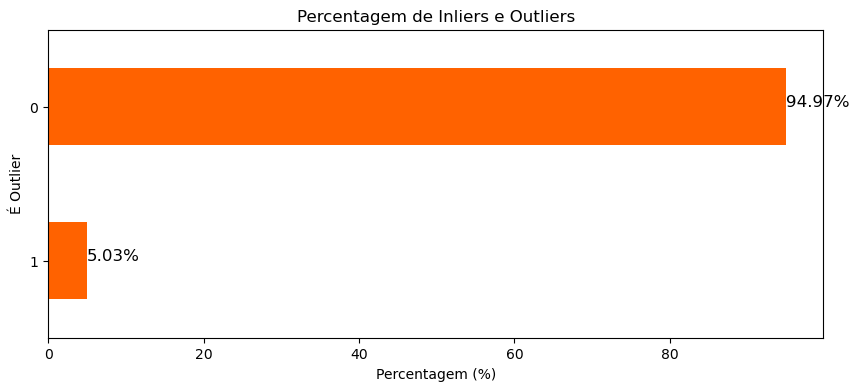

In [54]:
outlier_percentage = airport_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=12)

plt.title('Percentagem de Inliers e Outliers')
plt.xlabel('Percentagem (%)')
plt.ylabel('É Outlier')
plt.gca().invert_yaxis()
plt.show()

In [55]:
# Guardar os outliers
airport_outliers = airport_data[airport_data['Is_Outlier'] == 1]

# Remover os outliers
airport_data_cleaned = airport_data[airport_data['Is_Outlier'] == 0].copy()

# Remover colunas auxiliares
airport_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'], inplace=True)

# Reset índice
airport_data_cleaned.reset_index(drop=True, inplace=True)

In [56]:
airport_data_cleaned.shape[0]

359

<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 5 | Correlation Analysis</p>

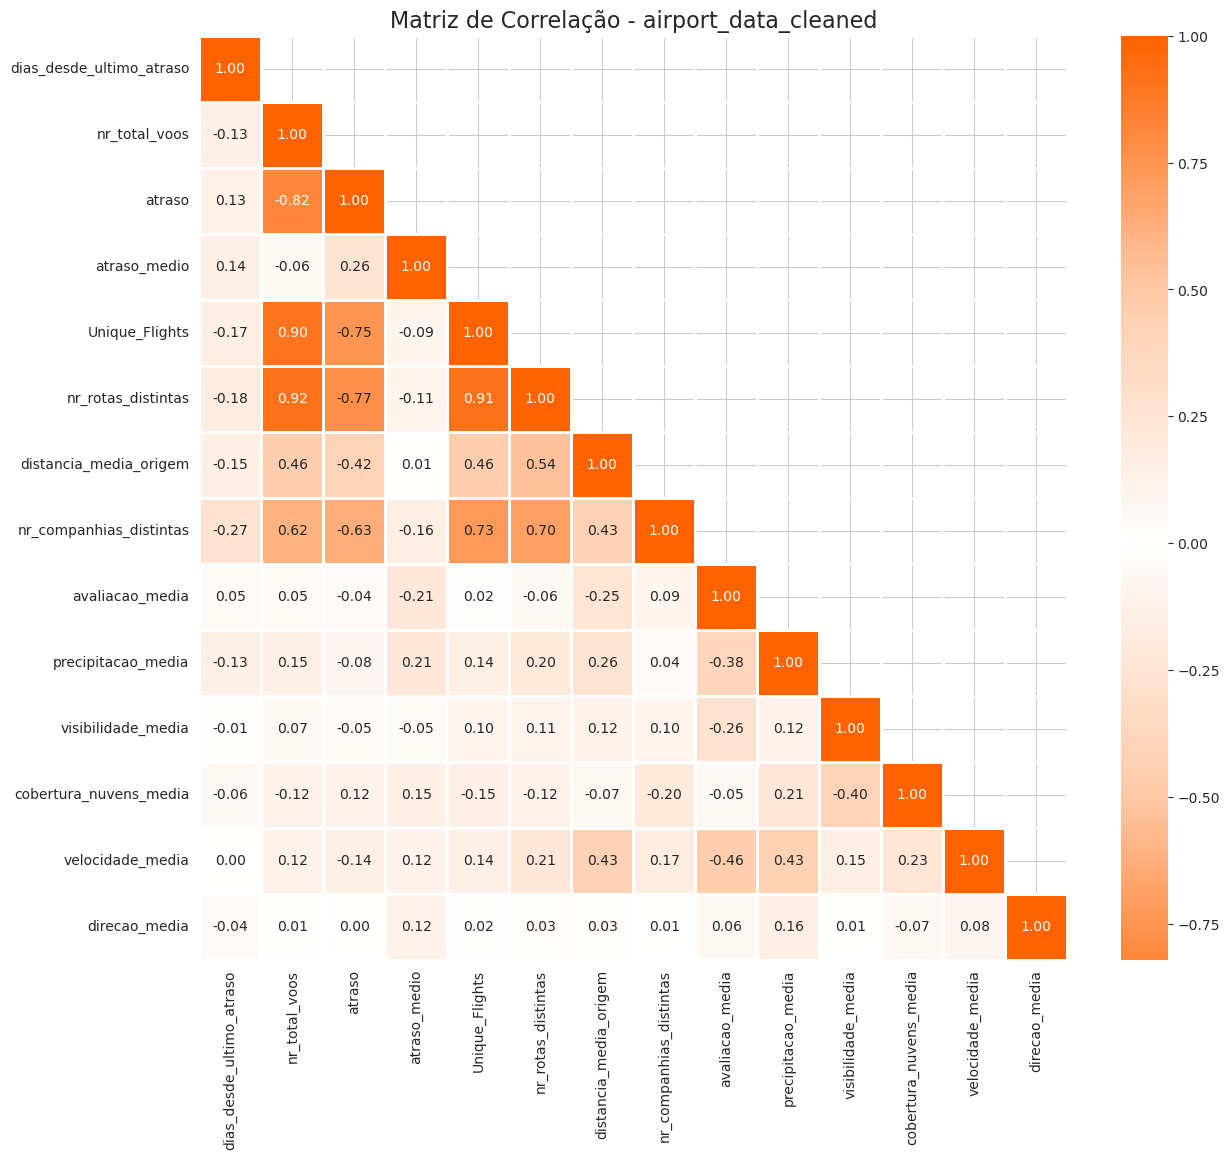

In [57]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Estilo do gráfico
sns.set_style('whitegrid')

# Selecionar apenas colunas numéricas
airport_numeric = airport_data_cleaned.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação
corr = airport_numeric.corr()

# Definir o colormap personalizado
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Criar máscara para mostrar apenas o triângulo inferior
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot do heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Matriz de Correlação - airport_data_cleaned', fontsize=16)
plt.show()
